Using the good old MNIST digits, we'll explore hyper parameters. First up -- let's load and normalize the digits.

In [1]:
import numpy as np
import seaborn as sns
import math

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, Conv2D, BatchNormalization, ZeroPadding2D, Reshape
from keras.models import Model, Sequential
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
import keras.wrappers.scikit_learn
import scipy.stats

sns.set()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
train_images = np.expand_dims(x_train / np.max(x_train), -1)
test_images = np.expand_dims(x_test / np.max(x_test), -1)
train_labels = keras.utils.to_categorical(y_train, 10)
test_labels = keras.utils.to_categorical(y_test, 10)
train_images.shape, train_labels.shape

((60000, 28, 28, 1), (60000, 10))

This is the same build function we used with Grid Search, but just as a reminder -- the idea is to adapt Keras interface to Scikit learn interface.

Scikit learn has a great 'standardized' interface that we can use with keras. This requires a 'build function' -- which creates a model.

This build function has a set of parameters -- hyperparameters -- that we will vary in order to find a 'best' model.


In [4]:
input_shape = train_images[0].shape
num_classes = 10

def builder(activation='relu', depth=1, pool=3, 
            strides=2, filters=32, hidden=64, dropout=0.0,
            loss='categorical_crossentropy', optimzer='adam'):
    model = Sequential()
    # initial reshape to have consistent layering
    model.add(Reshape(input_shape, input_shape=input_shape))
    
    # convolutional stack
    for i in range(depth):
        model.add(Conv2D(filters, pool, activation=activation))
        model.add(ZeroPadding2D(pool//2))
        model.add(MaxPooling2D(pool, strides=strides))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    # multilayer perceptron
    model.add(Flatten())
    for i in range(depth):
        model.add(Dense(hidden, activation=activation))
        if dropout > 0:
            model.add(Dropout(dropout))
    # final class activation
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimzer, metrics=['accuracy'])
    return model

classifier = keras.wrappers.scikit_learn.KerasClassifier(builder)

In [5]:
classifier.fit(train_images, train_labels)

Epoch 1/1
60000/60000 [==============================] - 33s 548us/step - loss: 0.1508 - acc: 0.9540


Since we already have separated testing data, we'll use a custom cross validator to split at the index point where the training images end, and then just concatenate the training and testing data end to end. 

The `PredefinedSplit` let's us declare which samples are training `-1` and testing folds. We'll use only one testing fold, with a value of `0`, which is the 0 index.

In [6]:
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)
train_test_bitmap = np.concatenate(
    (np.full(len(train_images), -1), np.zeros(len(test_images))),
    axis=0)

train_test_data = PredefinedSplit(train_test_bitmap)


Now the actual randomized search. This is different than grid search in that each iteration, which is a kind of meta-epoch, takes a random sample for each parameter. This sampling is done on a probability distribution, so you need to think about what kind of numbers you need `int` or `float`, as well as the range of values that you think are valid.

And -- you need to pick a probability distribution, whether something flat, a uniform distribution like how dice or a quarter work, or something more sophisticated like a gaussian or an exponential that samples values with different probabilities.

There are no hard and fast rules to the best distribution to use, they are arrived at by experiment.

## Exponential
Here is a look at what the values are like in an exponential, first with the default scale of 1, and then with a scale of 0.1.

Scikit learn is taking a large number of random samples, so we'll simulate that by making a list of sampled values.

You can see that it is mostly 0-0.1 -- that's the effect of scale, but in practice higher values can occur.

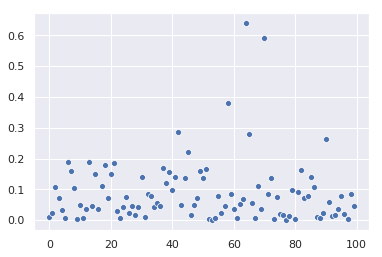

In [7]:
sample_indexes = [i for i in range(0, 100)]
exponential = scipy.stats.expon(scale=0.1)
samples = [exponential.rvs() for x in sample_indexes]
sns.scatterplot(sample_indexes, samples)

## Uniform
This is really two options -- uniform float and uniform integers, let's take a look at both. You'll see the numbers are evenly spread across the range.

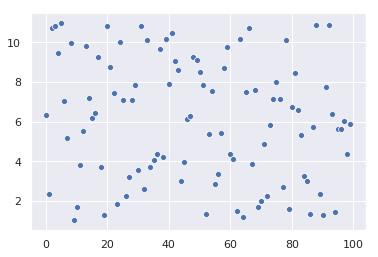

In [8]:
uniform = scipy.stats.uniform(1, 10)
samples = [uniform.rvs() for x in sample_indexes]
sns.scatterplot(sample_indexes, samples)

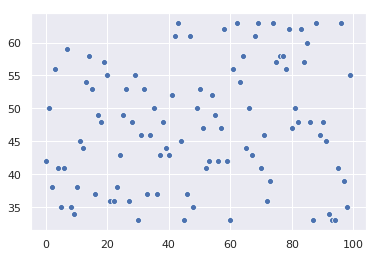

In [9]:
integers = scipy.stats.randint(32, 64)
samples = [integers.rvs() for x in sample_indexes]
sns.scatterplot(sample_indexes, samples)

## Normal
Use this when you want numbers to hover around a midpoint, by default around zero. Now notice in this graph that this probably doesn't look like the bell curve you would expect -- that's because we have the sample index as the X axis. What you can see is the density is around `0.5` -- that's the peak of the bell.

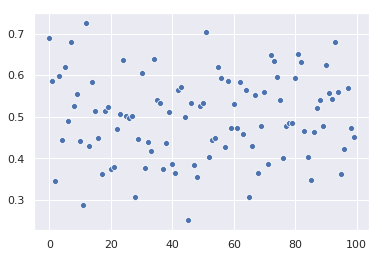

In [10]:
normal = scipy.stats.norm(loc=0.5, scale=0.1)
samples = [normal.rvs() for x in sample_indexes]
sns.scatterplot(sample_indexes, samples)

Randomized search doesn't cover every possible permutation of parameters, it runs for `n_iter` iterations. Just a warning, this is going to take a **long while to run**. However, you can control the number of iterations to suit your time, patience, or compute budget.

The second thing to note is you can mix lists of parameters with distributions. The lists get a random pick from the options. The distributions get a random value generated. This is pretty cool, you can mix nominal parameters like activations with numerical parameters easily.


In [12]:
param_distributions = {
    'epochs': scipy.stats.randint(1, 16),
    'activation': ['relu', 'elu'],
    'depth': scipy.stats.randint(1, 3),
    'filters': scipy.stats.randint(32, 128),
    'hidden': scipy.stats.randint(64, 256),
    'dropout': scipy.stats.norm(loc=0.5, scale=0.1)
}
grid = RandomizedSearchCV(estimator=classifier, 
                    param_distributions=param_distributions, 
                    refit=False,
                    verbose=1,
                    n_iter=16,
                    cv=train_test_data)
grid_result = grid.fit(all_images, all_labels)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 1 folds for each of 16 candidates, totalling 16 fits
Epoch 1/9
60000/60000 [==============================] - 43s 717us/step - loss: 0.1959 - acc: 0.9401
Epoch 2/9
60000/60000 [==============================] - 42s 708us/step - loss: 0.1107 - acc: 0.9656
Epoch 3/9
60000/60000 [==============================] - 42s 708us/step - loss: 0.0969 - acc: 0.9695
Epoch 4/9
60000/60000 [==============================] - 42s 707us/step - loss: 0.0840 - acc: 0.9740
Epoch 5/9
60000/60000 [==============================] - 42s 706us/step - loss: 0.0778 - acc: 0.9761
Epoch 6/9
60000/60000 [==============================] - 42s 705us/step - loss: 0.0712 - acc: 0.9781
Epoch 7/9
60000/60000 [==============================] - 42s 707us/step - loss: 0.0626 - acc: 0.9803
Epoch 8/9
60000/60000 [==============================] - 42s 704us/step - loss: 0.0614 - acc: 0.9811
Epoch 9/9
60000/60000 [==============================] - 13s 222us/step
Epoch 1/13
60000/60000 [==============================] - 7

60000/60000 [==============================] - 88s 1ms/step - loss: 0.1348 - acc: 0.9639
Epoch 3/3
60000/60000 [==============================] - 24s 400us/step
Epoch 1/9
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1531 - acc: 0.9530
Epoch 2/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0786 - acc: 0.9759
Epoch 3/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0661 - acc: 0.9799
Epoch 4/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0587 - acc: 0.9818
Epoch 5/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0449 - acc: 0.9859
Epoch 6/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0430 - acc: 0.9867
Epoch 7/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0412 - acc: 0.9870
Epoch 8/9
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0376 - acc: 0.9880
Epoch 9/9
60000/60000 [========================

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 150.8min finished


That's pretty cool. I bet you never would have picked those parameters by hand -- *panda* style!